In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [53]:
df = pd.read_csv('AEP_hourly.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22513 entries, 0 to 22512
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  22513 non-null  object
 1   AEP_MW    22513 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 351.9+ KB


In [54]:
df

,Datetime,AEP_MW
0,12/31/2004 1:00,13478
1,12/31/2004 2:00,12865
2,12/31/2004 3:00,12577
3,12/31/2004 4:00,12517
4,12/31/2004 5:00,12670
...,...,...
22508,9/6/2007 3:00,14515
22509,9/6/2007 4:00,14169
22510,9/6/2007 5:00,14265
22511,9/6/2007 6:00,14850


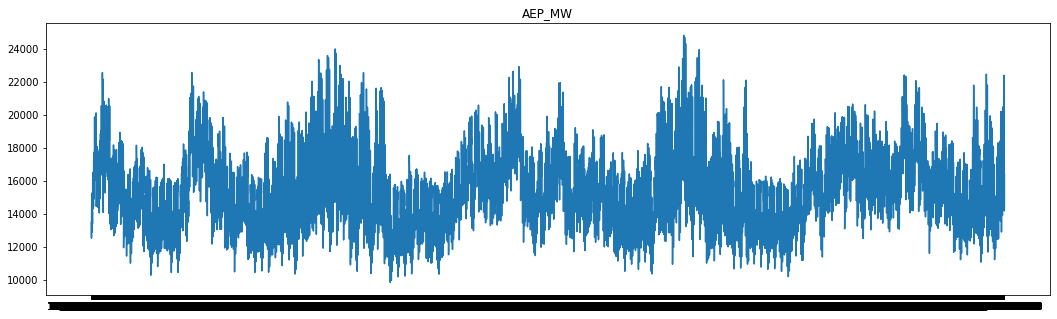

In [55]:
dates = df['Datetime'].values
label = df['AEP_MW'].values
label = label.reshape(-1,1)

plt.figure(figsize=(18,5))
plt.plot(dates, label)
plt.title('AEP_MW')

scaler = MinMaxScaler()
scaled_label = scaler.fit_transform(label)
scaled_label = scaled_label.reshape(1,-1)
scaled_label = np.hstack(scaled_label)

X_train, X_test, y_train, y_test = train_test_split(dates, scaled_label, test_size=0.2, random_state=1, shuffle=False)

In [56]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [57]:
skala_data = (max(scaled_label) - min(scaled_label)) * 0.1
print(skala_data)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mae') < skala_data) and (logs.get('val_mae') < skala_data):
            self.model.stop_training = True;
            print('\nMae telah dibawah 10% dari skala data yaitu {}'.format(skala_data))

callbacks = myCallback()

0.1


In [58]:
train_set = windowed_dataset(y_train, window_size=90, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(y_test, window_size=90, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
    ])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-01, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=['mae']
    )
hist = model.fit(
    train_set,
    epochs=100,
    validation_data=val_set,
    verbose=2,
    callbacks=[callbacks],
    )

Epoch 1/100
180/180 - 10s - loss: 0.0144 - mae: 0.1343 - val_loss: 0.0102 - val_mae: 0.1177 - 10s/epoch - 56ms/step
Epoch 2/100
180/180 - 6s - loss: 0.0098 - mae: 0.1118 - val_loss: 0.0061 - val_mae: 0.0889 - 6s/epoch - 32ms/step
Epoch 3/100

Mae telah dibawah 10% dari skala data yaitu 0.1
180/180 - 6s - loss: 0.0073 - mae: 0.0958 - val_loss: 0.0054 - val_mae: 0.0833 - 6s/epoch - 32ms/step


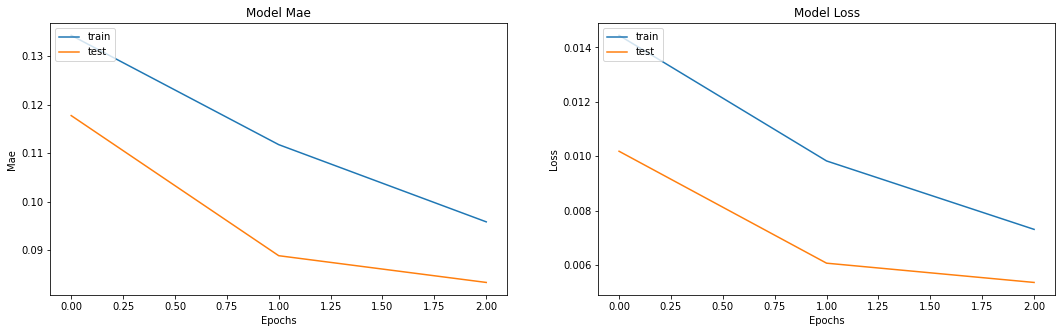

In [59]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('Model Mae')
plt.xlabel('Epochs')
plt.ylabel('Mae')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')

plt.show()